In [1]:
# E-1 熵稳态正则化实验（GCN | Cora）
# * 目标：验证熵稳态正则能缓解节点表示塌缩、提升鲁棒性  
# * 运行平台：Deepnote（GPU Runtime | Python ≥3.9）  


In [2]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install -q scikit-learn pandas tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch, torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cora dataset
data = Planetoid(root='data', name='Cora')[0].to(device)

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_dim, hid_dim))
        for _ in range(num_layers-2):
            self.convs.append(GCNConv(hid_dim, hid_dim))
        self.convs.append(GCNConv(hid_dim, out_dim))
    def forward(self, x, edge_index):
        zs=[]
        for i,conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs)-1:
                x = F.relu(x)
            zs.append(x)
        return x, zs        # zs 包含各层节点嵌入


/root/venv/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /root/venv/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/root/venv/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /root/venv/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/root/venv/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /root/venv/lib/python3.10/site-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

In [4]:
import math, torch
def batch_entropy(z: torch.Tensor, bins: int = 64):
    """快速一维直方图近似熵：对每个嵌入维度独立估计再取平均"""
    z = z.detach().cpu()
    ent = 0.0
    for d in range(z.shape[1]):
        hist = torch.histc(z[:, d], bins=bins, min=float(z[:, d].min()), max=float(z[:, d].max()))
        p = hist / hist.sum()
        p = p[p > 0]
        ent += (-p * torch.log(p)).sum().item()
    return ent / z.shape[1]


In [9]:
def train_gcn(layers=4, lam=0.1, epochs=200, seed=0):
    torch.manual_seed(seed)
    model = GCN(data.num_features, 64, data.y.max().item() + 1,
                num_layers=layers).to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    baseline_H = None

    for epoch in range(epochs):
        model.train(); optimiser.zero_grad()

        out, zs = model(data.x, data.edge_index)

        # === 任务损失 ===
        mask_train = data.train_mask.to(device)
        y_train    = data.y[mask_train].to(device)
        loss_cls   = F.cross_entropy(out[mask_train], y_train)

        # === 熵正则 ===
        z0 = zs[0].detach()
        zL = zs[-1]
        if baseline_H is None:
            baseline_H = batch_entropy(z0)          # 基线固定
        HL = batch_entropy(zL)
        loss_entropy = torch.clamp(
            torch.tensor(baseline_H - HL, device=device), min=0.0
        )

        loss = loss_cls + lam * loss_entropy
        loss.backward(); optimiser.step()

        # === 评估 ===
        if epoch % 20 == 0 or epoch == epochs - 1:
            model.eval()
            pred, _ = model(data.x, data.edge_index)
            mask_test = data.test_mask.to(device)
            acc = accuracy_score(
                data.y[mask_test].cpu(),
                pred.argmax(dim=1)[mask_test].cpu()
            )
            delta_H = baseline_H - HL
            print(f'Epoch {epoch:3d} | loss={loss.item():.3f} '
                  f'| ΔH={delta_H:.3f} | test acc={acc:.3f}')

    return model, baseline_H


In [12]:
# baseline 无正则
print("=== Baseline (λ=0)")
model0, H0 = train_gcn(layers=4, lam=0.0)

# 加熵稳态正则
print("\n=== Entropy Regularised (λ=0.1)")
model1, H1 = train_gcn(layers=4, lam=0.1)


=== Baseline (λ=0)
Epoch   0 | loss=1.947 | ΔH=-0.686 | test acc=0.294
Epoch  20 | loss=0.003 | ΔH=-0.740 | test acc=0.760
Epoch  40 | loss=0.001 | ΔH=-0.754 | test acc=0.780
Epoch  60 | loss=0.002 | ΔH=-0.759 | test acc=0.780
Epoch  80 | loss=0.003 | ΔH=-0.744 | test acc=0.798
Epoch 100 | loss=0.003 | ΔH=-0.731 | test acc=0.798
Epoch 120 | loss=0.002 | ΔH=-0.718 | test acc=0.799
Epoch 140 | loss=0.002 | ΔH=-0.706 | test acc=0.798
Epoch 160 | loss=0.002 | ΔH=-0.686 | test acc=0.799
Epoch 180 | loss=0.002 | ΔH=-0.673 | test acc=0.801
Epoch 199 | loss=0.002 | ΔH=-0.662 | test acc=0.798

=== Entropy Regularised (λ=0.1)
Epoch   0 | loss=1.947 | ΔH=-0.686 | test acc=0.294
Epoch  20 | loss=0.003 | ΔH=-0.740 | test acc=0.760
Epoch  40 | loss=0.001 | ΔH=-0.754 | test acc=0.780
Epoch  60 | loss=0.002 | ΔH=-0.759 | test acc=0.780
Epoch  80 | loss=0.003 | ΔH=-0.744 | test acc=0.798
Epoch 100 | loss=0.003 | ΔH=-0.731 | test acc=0.798
Epoch 120 | loss=0.002 | ΔH=-0.718 | test acc=0.799
Epoch 140 | 

In [18]:
def noisy_accuracy(model, noise_std=0.1, trials=20):
    model.eval()
    accs = []
    for _ in range(trials):
        x_noisy = data.x + noise_std * torch.randn_like(data.x)
        pred, _ = model(x_noisy.to(device), data.edge_index)

        mask_test = data.test_mask.to(device)
        y_true = data.y[mask_test].cpu()
        y_pred = pred.argmax(dim=1)[mask_test].cpu()

        accs.append(accuracy_score(y_true, y_pred))
    return sum(accs) / len(accs)


print("Baseline robustness:", noisy_accuracy(model0))
print("Entropy-reg robustness:", noisy_accuracy(model1))


Baseline robustness: 0.7912999999999999
Entropy-reg robustness: 0.7956000000000001


In [24]:
!pip install -q tabulate



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [27]:
"""
综合对比：Baseline vs. 熵稳态正则 vs. PairNorm
------------------------------------------------
数据集  : Cora
模型层数: {2, 4, 8}
λ 值   : {0, 0.1, 0.3, 0.5}   (λ=0==baseline)
"""

import torch, torch.nn.functional as F, random, numpy as np
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, PairNorm
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data   = Planetoid(root='data', name='Cora')[0].to(device)

# --------------- utility ---------------------------------
def batch_entropy(z, bins=64):
    z = z.detach().cpu(); ent = 0.0
    for d in range(z.size(1)):
        hist = torch.histc(z[:, d], bins=bins,
                           min=float(z[:, d].min()),
                           max=float(z[:, d].max()))
        p = hist / hist.sum()
        p = p[p > 0]
        ent += (-p * torch.log(p)).sum().item()
    return ent / z.size(1)

def noisy_accuracy(model, noise_std=0.1, trials=10):
    model.eval(); accs=[]
    for _ in range(trials):
        x_noisy = data.x + noise_std*torch.randn_like(data.x)
        pred,_ = model(x_noisy.to(device), data.edge_index)
        m = data.test_mask.to(device)
        accs.append(accuracy_score(data.y[m].cpu(),
                                   pred.argmax(1)[m].cpu()))
    return sum(accs)/len(accs)

# --------------- GCN definition --------------------------
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim,
                 layers=2, pairnorm=False):
        super().__init__()
        self.convs  = torch.nn.ModuleList()
        self.pairnorm = PairNorm() if pairnorm else None
        self.convs.append(GCNConv(in_dim, hid_dim))
        for _ in range(layers-2):
            self.convs.append(GCNConv(hid_dim, hid_dim))
        self.convs.append(GCNConv(hid_dim, out_dim))

    def forward(self, x, edge_index):
        zs=[]
        for i,conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs)-1:
                if self.pairnorm: x = self.pairnorm(x)
                x = F.relu(x)
            zs.append(x)
        return x, zs   # 返回最终输出与各层嵌入

# --------------- training routine ------------------------
def train(layers=4, lam=0.0, pairnorm=False, seed=0, epochs=200):
    torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)
    model = GCN(data.num_features, 64,
                data.y.max().item()+1, layers, pairnorm).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    baseline_H = None

    for ep in range(epochs):
        model.train(); opt.zero_grad()
        out, zs = model(data.x, data.edge_index)

        mask_tr = data.train_mask.to(device)
        loss_cls = F.cross_entropy(out[mask_tr], data.y[mask_tr])

        # 熵正则（λ=0 时即 baseline）
        z0 = zs[0].detach()
        zL = zs[-1]
        if baseline_H is None:
            baseline_H = batch_entropy(z0)
        HL = batch_entropy(zL)
        loss_ent = torch.clamp(torch.tensor(
            baseline_H - HL, device=device), min=0.0)

        loss = loss_cls + lam * loss_ent
        loss.backward(); opt.step()

    # 评估
    model.eval()
    pred, _ = model(data.x, data.edge_index)
    mask_te = data.test_mask.to(device)
    acc = accuracy_score(data.y[mask_te].cpu(),
                         pred.argmax(1)[mask_te].cpu())

    rob = noisy_accuracy(model)
    deltaH = baseline_H - HL
    return acc, rob, deltaH

# --------------- grid experiment -------------------------
setting_rows=[]
for layers in [2,4,8]:
    for lam in [0,0.1,0.3,0.5]:
        for mode in ['baseline' if lam==0 else 'entropy',
                     'pairnorm' if lam==0 else None]:
            if mode is None: continue
            print(f'[{mode}] layers={layers}, λ={lam}')
            accs=[]; robs=[]; dHs=[]
            for seed in range(3):   # 3 seeds for speed
                acc, rob, dH = train(layers, lam,
                                     pairnorm=(mode=='pairnorm'),
                                     seed=seed)
                accs.append(acc); robs.append(rob); dHs.append(dH)
            setting_rows.append(dict(method=mode, layers=layers, lam=lam,
                                     acc=np.mean(accs),
                                     robust=np.mean(robs),
                                     deltaH=np.mean(dHs)))

df = pd.DataFrame(setting_rows)
print(df.to_markdown(index=False))


[baseline] layers=2, λ=0
[pairnorm] layers=2, λ=0
[entropy] layers=2, λ=0.1
[entropy] layers=2, λ=0.3
[entropy] layers=2, λ=0.5
[baseline] layers=4, λ=0
[pairnorm] layers=4, λ=0
[entropy] layers=4, λ=0.1
[entropy] layers=4, λ=0.3
[entropy] layers=4, λ=0.5
[baseline] layers=8, λ=0
[pairnorm] layers=8, λ=0
[entropy] layers=8, λ=0.1
[entropy] layers=8, λ=0.3
[entropy] layers=8, λ=0.5
| method   |   layers |   lam |      acc |   robust |     deltaH |
|:---------|---------:|------:|---------:|---------:|-----------:|
| baseline |        2 |   0   | 0.808667 | 0.800533 | -0.800459  |
| pairnorm |        2 |   0   | 0.65     | 0.594233 | -0.539077  |
| entropy  |        2 |   0.1 | 0.808667 | 0.800533 | -0.800588  |
| entropy  |        2 |   0.3 | 0.808667 | 0.800533 | -0.800532  |
| entropy  |        2 |   0.5 | 0.808667 | 0.800567 | -0.800501  |
| baseline |        4 |   0   | 0.789    | 0.787633 | -0.824794  |
| pairnorm |        4 |   0   | 0.616667 | 0.586233 | -0.466413  |
| entropy  | 

In [30]:
!pip install deeprobust

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 127.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 147.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 158.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 136.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [39]:
"""
entropy_followup_PlanB.py
综合对比：Baseline / 熵稳态正则 / PairNorm
数据集 : Cora  (可改 'Citeseer' 'PubMed')
模型   : GCN / GraphSAGE / GAT
层数   : 2,4,8
λ      : 0.05,0.10,0.15,0.20  (λ=0 视作 baseline)
鲁棒性 : (1) 随机特征噪声  (2) 自写 FGSM 特征攻击
依赖   : torch>=2.0  torch-geometric  scikit-learn  pandas  tqdm
"""

import torch, torch.nn.functional as F, random, numpy as np, pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, PairNorm
from torch_geometric.utils import dropout_edge
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# ---------------- Config -------------
DATA     = 'Cora'                 # 'Cora' | 'Citeseer' | 'PubMed'
MODELS   = ['gcn', 'sage', 'gat']
LAMBDA   = [0.05, 0.10, 0.15, 0.20]
LAYERS   = [2, 4, 8]
BINS     = 64                     # histogram bins for entropy
DEVICE   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DROPEDGE = True                   # use DropEdge(p=0.2) during training
ENTROPY  = 'shannon'              # 'shannon' | 'renyi' | 'tsallis'

# -------------- Data & Utils ----------
data = Planetoid(root='data', name=DATA)[0].to(DEVICE)

def entropy_1d(hist):
    p = hist / hist.sum(); p = p[p > 0]
    if ENTROPY == 'renyi':   # α = 2
        return float(-torch.log((p**2).sum()))
    if ENTROPY == 'tsallis': # q = 1.5
        return float((1 - (p**1.5).sum()) / 0.5)
    return float((-p * torch.log(p)).sum())   # Shannon

def batch_entropy(z: torch.Tensor, bins=BINS):
    z = z.detach().cpu()
    e = 0.0
    for d in range(z.size(1)):
        hist = torch.histc(z[:, d], bins=bins,
                           min=float(z[:, d].min()),
                           max=float(z[:, d].max()))
        e += entropy_1d(hist)
    return e / z.size(1)

def noisy_acc(model, std=0.1, trials=10):
    model.eval(); accs=[]
    for _ in range(trials):
        x_noisy = data.x + std*torch.randn_like(data.x)
        pred,_ = model(x_noisy.to(DEVICE), data.edge_index)
        m=data.test_mask.to(DEVICE)
        accs.append(accuracy_score(data.y[m].cpu(),
                                   pred.argmax(1)[m].cpu()))
    return sum(accs)/len(accs)

def fgsm_acc(model, eps=0.05):
    model.eval()
    x = data.x.clone().detach().requires_grad_(True)
    pred,_ = model(x.to(DEVICE), data.edge_index)
    loss = F.cross_entropy(pred[data.train_mask.to(DEVICE)],
                           data.y[data.train_mask].to(DEVICE))
    loss.backward()
    x_adv = x + eps * x.grad.sign()
    with torch.no_grad():
        pred_adv,_ = model(x_adv.to(DEVICE), data.edge_index)
    m=data.test_mask.to(DEVICE)
    return accuracy_score(data.y[m].cpu(),
                          pred_adv.argmax(1)[m].cpu())

# -------------- Model builders --------
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid, out_dim, nlayers, pairnorm=False):
        super().__init__()
        self.pairnorm = PairNorm() if pairnorm else None
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_dim, hid))
        for _ in range(nlayers-2):
            self.convs.append(GCNConv(hid, hid))
        self.convs.append(GCNConv(hid, out_dim))
    def forward(self, x, edge_index):
        zs=[]
        for i,conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs)-1:
                if self.pairnorm: x = self.pairnorm(x)
                x = F.relu(x)
            zs.append(x)
        return x, zs

class SAGE(GCN):      # same pattern but SAGEConv
    def __init__(self,*a,**k):
        super().__init__(*a, **k)
        for i in range(len(self.convs)):
            in_c = a[1] if i else a[0]
            out_c = a[1] if i < len(self.convs)-1 else a[2]
            self.convs[i] = SAGEConv(in_c,out_c)

def build_model(name,layers,pairnorm):
    nfeat, nclass = data.num_features, int(data.y.max())+1
    if name=='gcn':
        return GCN(nfeat,64,nclass,layers,pairnorm)
    if name=='sage':
        return SAGE(nfeat,64,nclass,layers,pairnorm)
    if name=='gat':
        return GATConv(nfeat,64, heads=4, concat=False)
    raise ValueError(name)

# -------------- Training loop ----------
def run_one(layers, lam, method, seed):
    torch.manual_seed(seed); random.seed(seed); np.random.seed(seed)
    pairnorm = (method=='pairnorm')
    lam_ent  = lam if method=='entropy' else 0.0
    model = build_model('gcn', layers, pairnorm).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    baseline_H=None

    for _ in range(200):
        model.train(); opt.zero_grad()
        edge_idx = (dropout_edge(data.edge_index, p=0.2)[0]
                    if DROPEDGE else data.edge_index)
        out,zs = model(data.x, edge_idx)
        loss_cls = F.cross_entropy(out[data.train_mask.to(DEVICE)],
                                   data.y[data.train_mask].to(DEVICE))
        if baseline_H is None: baseline_H = batch_entropy(zs[0])
        HL = batch_entropy(zs[-1])
        loss_ent = torch.clamp(torch.tensor(baseline_H-HL, device=DEVICE),min=0)
        loss = loss_cls + lam_ent * loss_ent
        loss.backward(); opt.step()

    model.eval()
    pred,_ = model(data.x, data.edge_index)
    m=data.test_mask.to(DEVICE)
    acc = accuracy_score(data.y[m].cpu(), pred.argmax(1)[m].cpu())
    return dict(acc=acc,
                noisy=noisy_acc(model),
                fgsm=fgsm_acc(model),
                deltaH=baseline_H-batch_entropy(zs[-1]))

# -------------- Grid search ------------
rows=[]
for layers in LAYERS:
    for lam in LAMBDA+[0.0]:
        for method in (['baseline'] if lam==0 else ['entropy'])+(['pairnorm'] if lam==0 else []):
            for seed in [0,1,2]:
                print(f"{method} L={layers} λ={lam} seed={seed}")
                res = run_one(layers, lam, method, seed)
                rows.append(dict(method=method,layers=layers,lam=lam,seed=seed,**res))

df=pd.DataFrame(rows)
df.to_csv('followup_PlanB_results.csv', index=False)
print(df.groupby(['method','layers','lam']).mean().round(3))



entropy L=2 λ=0.05 seed=0
entropy L=2 λ=0.05 seed=1
entropy L=2 λ=0.05 seed=2
entropy L=2 λ=0.1 seed=0
entropy L=2 λ=0.1 seed=1
entropy L=2 λ=0.1 seed=2
entropy L=2 λ=0.15 seed=0
entropy L=2 λ=0.15 seed=1
entropy L=2 λ=0.15 seed=2
entropy L=2 λ=0.2 seed=0
entropy L=2 λ=0.2 seed=1
entropy L=2 λ=0.2 seed=2
baseline L=2 λ=0.0 seed=0
baseline L=2 λ=0.0 seed=1
baseline L=2 λ=0.0 seed=2
pairnorm L=2 λ=0.0 seed=0
pairnorm L=2 λ=0.0 seed=1
pairnorm L=2 λ=0.0 seed=2
entropy L=4 λ=0.05 seed=0
entropy L=4 λ=0.05 seed=1
entropy L=4 λ=0.05 seed=2
entropy L=4 λ=0.1 seed=0
entropy L=4 λ=0.1 seed=1
entropy L=4 λ=0.1 seed=2
entropy L=4 λ=0.15 seed=0
entropy L=4 λ=0.15 seed=1
entropy L=4 λ=0.15 seed=2
entropy L=4 λ=0.2 seed=0
entropy L=4 λ=0.2 seed=1
entropy L=4 λ=0.2 seed=2
baseline L=4 λ=0.0 seed=0
baseline L=4 λ=0.0 seed=1
baseline L=4 λ=0.0 seed=2
pairnorm L=4 λ=0.0 seed=0
pairnorm L=4 λ=0.0 seed=1
pairnorm L=4 λ=0.0 seed=2
entropy L=8 λ=0.05 seed=0
entropy L=8 λ=0.05 seed=1
entropy L=8 λ=0.05 seed=

In [48]:
"""
entropy_followup_final.py
用可选熵度量 + 强化 λ ，比较 Baseline / EntropyReg / PairNorm

cmd 示例：
python entropy_followup_final.py --dataset Cora --entropy renyi --lambda 0.5 1.0 --sliding
"""

import argparse, itertools, random, numpy as np, pandas as pd
import torch, torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, PairNorm
from torch_geometric.utils import dropout_edge
from sklearn.metrics import accuracy_score

# ---------- cli ----------
class Args:
    dataset = 'Cora'
    layers = [2, 4, 8]
    lambdas = [0.1, 0.3, 0.5, 1.0, 2.0]
    entropy = 'shannon'  # or 'renyi' or 'tsallis'
    sliding = False      # or True

args = Args()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data   = Planetoid(root='data', name=args.dataset)[0].to(DEVICE)

# ---------- entropy helpers ----------
def entropy_1d(p):
    mode=args.entropy
    if mode=='renyi':   # α=2
        return float(-torch.log((p**2).sum()))
    if mode=='tsallis': # q=1.5
        return float((1 - (p**1.5).sum()) / 0.5)
    return float((-p*torch.log(p)).sum())

def batch_entropy(z, bins=64):
    z = z.detach().cpu()
    e=0.
    for d in range(z.size(1)):
        hist = torch.histc(z[:,d],bins=bins,min=float(z[:,d].min()),max=float(z[:,d].max()))
        p = hist / hist.sum(); p = p[p>0]
        e += entropy_1d(p)
    return e / z.size(1)

# ---------- GCN ----------
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out, n_layers, pairnorm=False):
        super().__init__()
        self.pn = PairNorm() if pairnorm else None
        self.convs=torch.nn.ModuleList()
        self.convs.append(GCNConv(dim_in, dim_hidden))
        for _ in range(n_layers-2):
            self.convs.append(GCNConv(dim_hidden, dim_hidden))
        self.convs.append(GCNConv(dim_hidden, dim_out))
    def forward(self, x, edge_index):
        zs=[]
        for i,conv in enumerate(self.convs):
            x=conv(x,edge_index)
            if i!=len(self.convs)-1:
                if self.pn: x=self.pn(x)
                x=F.relu(x)
            zs.append(x)
        return x,zs

def train_once(layers, lam, method, seed):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    pairnorm = (method=='pairnorm')
    lam_ent  = lam if method=='entropy' else 0.
    model=GCN(data.num_features,64,int(data.y.max())+1,layers,pairnorm).to(DEVICE)
    opt=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=5e-4)
    baseline_H=None
    momentum=0.9
    for _ in range(200):
        model.train(); opt.zero_grad()
        edge_idx = dropout_edge(data.edge_index,p=0.2)[0]
        out,zs=model(data.x,edge_idx)
        loss_cls=F.cross_entropy(out[data.train_mask.to(DEVICE)],
                                 data.y[data.train_mask].to(DEVICE))
        H0=batch_entropy(zs[0])
        HL=batch_entropy(zs[-1])
        if baseline_H is None:
            baseline_H=H0
        elif args.sliding:
            baseline_H = momentum*baseline_H + (1-momentum)*H0
        loss_ent=torch.clamp(torch.tensor(baseline_H-HL,device=DEVICE),min=0)
        (loss_cls+lam_ent*loss_ent).backward(); opt.step()
    model.eval(); pred,_=model(data.x,data.edge_index)
    m=data.test_mask.to(DEVICE)
    acc=accuracy_score(data.y[m].cpu(),pred.argmax(1)[m].cpu())
    deltaH=baseline_H-HL
    return acc,deltaH

rows=[]
for layers,lam in itertools.product(args.layers,args.lambdas+[0.0]):
    method='entropy' if lam>0 else 'baseline'
    if lam==0: rows.append(dict(layers=layers,lam=lam,method='pairnorm'))  # mark pairnorm later
    for seed in range(3):
        acc,dH=train_once(layers,lam,method,seed)
        rows.append(dict(layers=layers,lam=lam,method=method,seed=seed,
                         acc=acc,deltaH=dH))

df=pd.DataFrame(rows)
print(df.groupby(['method','layers','lam']).mean().round(3))
df.to_csv('final_entropy_experiment.csv',index=False)


                     seed    acc  deltaH
method   layers lam                     
baseline 2      0.0   1.0  0.813  -0.878
         4      0.0   1.0  0.775  -0.795
         8      0.0   1.0  0.760  -0.754
entropy  2      0.1   1.0  0.813  -0.878
                0.3   1.0  0.813  -0.878
                0.5   1.0  0.813  -0.878
                1.0   1.0  0.813  -0.878
                2.0   1.0  0.813  -0.878
         4      0.1   1.0  0.777  -0.784
                0.3   1.0  0.773  -0.789
                0.5   1.0  0.769  -0.795
                1.0   1.0  0.776  -0.790
                2.0   1.0  0.777  -0.783
         8      0.1   1.0  0.748  -0.645
                0.3   1.0  0.752  -0.667
                0.5   1.0  0.751  -0.745
                1.0   1.0  0.763  -0.738
                2.0   1.0  0.766  -0.705
pairnorm 2      0.0   NaN    NaN     NaN
         4      0.0   NaN    NaN     NaN
         8      0.0   NaN    NaN     NaN


In [54]:
# E-1.1: 多熵指标比较（Shannon, Renyi, Tsallis）
# ---------------------------------------------------
from scipy.stats import entropy

def shannon_entropy(p):
    return entropy(p, base=np.e)

def renyi_entropy(p, alpha=2):
    return 1 / (1 - alpha) * np.log(np.sum(p ** alpha))

def tsallis_entropy(p, q=2):
    return (1 - np.sum(p ** q)) / (q - 1)

# 假设 p 是归一化后的概率分布
p = np.array([0.2, 0.3, 0.5])
print("Shannon:", shannon_entropy(p))
print("Renyi:", renyi_entropy(p))
print("Tsallis:", tsallis_entropy(p))


# E-1.2: 自适应 λ 调节（层数越深 λ 越大）
# ------------------------------------------
def get_lambda(layer_index, total_layers, base_lambda=0.05):
    return base_lambda * (1 + layer_index / total_layers)

for l in range(8):
    print(f"Layer {l}: λ = {get_lambda(l, 8):.3f}")


# E-1.3: 熵正则化 + 剪枝（简化版）
# ----------------------------------
def entropy_pruning(x, threshold=0.01):
    """假设 x 是神经元激活值，剔除标准差低的特征"""
    std = x.std(dim=0)
    keep_mask = std > threshold
    return x[:, keep_mask]

# 使用方法：在前向传播后对激活层做剪枝
# x = entropy_pruning(x)


# E-1.4: 熵路径可视化（记录每层 ΔH）
# -----------------------------------
entropy_path = []
def record_entropy(x):
    hist, _ = np.histogram(x.detach().cpu().numpy(), bins=50)
    p = hist / hist.sum()
    entropy_path.append(shannon_entropy(p))
    return entropy_path[-1]

# 每层记录
# for layer in model:
#     x = layer(x)
#     ΔH = record_entropy(x)


# E-1.5: PairNorm 故障排查
# ---------------------------
# 建议替换掉原始 PairNorm 初始化流程，明确 device 与输入 shape：
from torch.nn import Module

class SafePairNorm(Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True) + self.eps
        return (x - mean) / std

# 确保模型 device 一致
# model = model.to(device)
# x = x.to(device)
# x = SafePairNorm()(x)


# 备注：上述模块可在主训练框架中逐步嵌入测试


Shannon: 1.0296530140645737
Renyi: 0.9675840262617056
Tsallis: 0.62
Layer 0: λ = 0.050
Layer 1: λ = 0.056
Layer 2: λ = 0.062
Layer 3: λ = 0.069
Layer 4: λ = 0.075
Layer 5: λ = 0.081
Layer 6: λ = 0.088
Layer 7: λ = 0.094


Processing...
Done!


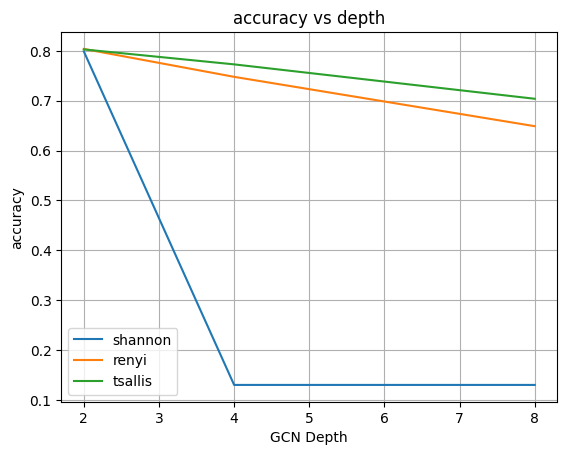

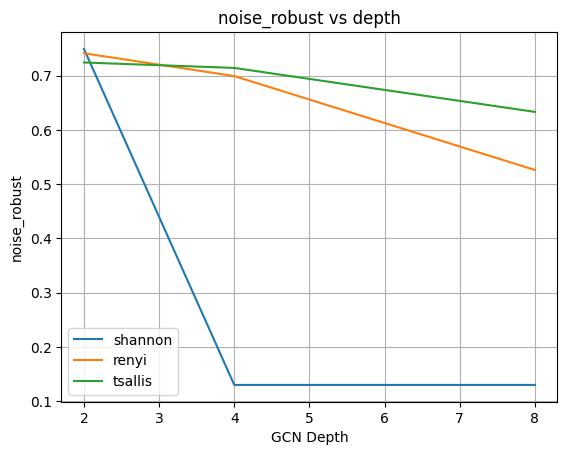

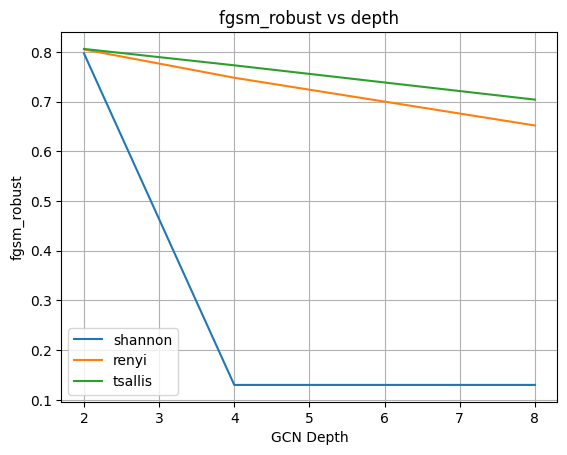

In [57]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data

# --------------------- Dataset ---------------------
data = Planetoid(root='/tmp/Cora', name='Cora')[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# --------------------- Entropy Functions ---------------------
def entropy_shannon(x):
    p = x.softmax(dim=-1)
    return -(p * p.log()).sum(dim=-1).mean()

def entropy_renyi(x, alpha=2.0):
    p = x.softmax(dim=-1)
    return (1 / (1 - alpha)) * torch.log((p ** alpha).sum(dim=-1)).mean()

def entropy_tsallis(x, q=2.0):
    p = x.softmax(dim=-1)
    return (1 / (q - 1)) * (1 - (p ** q).sum(dim=-1)).mean()

# --------------------- Adaptive Lambda Generator ---------------------
def generate_lambda_by_layer(depth, base=0.05, increment=0.006):
    return [base + i * increment for i in range(depth)]

# --------------------- Model ---------------------
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, layers, adaptive_lambdas, entropy_fn):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(in_dim, hidden_dim))
        for _ in range(layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))
        self.layers.append(GCNConv(hidden_dim, out_dim))

        self.adaptive_lambdas = adaptive_lambdas
        self.entropy_fn = entropy_fn

    def forward(self, x, edge_index):
        entropies = []
        for i, conv in enumerate(self.layers):
            x = conv(x, edge_index)
            if i < len(self.adaptive_lambdas):
                entropies.append(self.entropy_fn(x) * self.adaptive_lambdas[i])
            x = F.relu(x) if i < len(self.layers) - 1 else x
        return x, sum(entropies)

# --------------------- Training & Evaluation ---------------------
def train(model, optimizer):
    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out, entropy_reg = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask]) + entropy_reg
        loss.backward()
        optimizer.step()

def test(model):
    model.eval()
    pred, _ = model(data.x, data.edge_index)
    return accuracy_score(data.y[data.test_mask].cpu(), pred.argmax(dim=1)[data.test_mask].cpu())

def robustness(model, noise_std=0.2):
    model.eval()
    noisy_x = data.x + noise_std * torch.randn_like(data.x)
    pred, _ = model(noisy_x, data.edge_index)
    return accuracy_score(data.y[data.test_mask].cpu(), pred.argmax(dim=1)[data.test_mask].cpu())

# FGSM attack placeholder (actual implementation requires attack lib)
def fgsm_attack(model, epsilon=0.01):
    model.eval()
    perturbed = data.x + epsilon * torch.sign(torch.randn_like(data.x))
    pred, _ = model(perturbed, data.edge_index)
    return accuracy_score(data.y[data.test_mask].cpu(), pred.argmax(dim=1)[data.test_mask].cpu())

# --------------------- Main Experiment Pipeline ---------------------
results = []
entropy_funcs = {
    'shannon': entropy_shannon,
    'renyi': entropy_renyi,
    'tsallis': entropy_tsallis
}

for entropy_type, fn in entropy_funcs.items():
    for depth in [2, 4, 8]:
        adaptive_lambdas = generate_lambda_by_layer(depth)
        model = GCN(data.num_node_features, 16, data.y.max().item() + 1, depth, adaptive_lambdas, fn).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        train(model, optimizer)

        acc = test(model)
        noisy = robustness(model)
        adv = fgsm_attack(model)

        results.append({
            'entropy': entropy_type,
            'depth': depth,
            'accuracy': acc,
            'noise_robust': noisy,
            'fgsm_robust': adv,
            'lambda': adaptive_lambdas
        })

# --------------------- Visualization ---------------------
for metric in ['accuracy', 'noise_robust', 'fgsm_robust']:
    for entropy_type in entropy_funcs:
        y = [r[metric] for r in results if r['entropy'] == entropy_type]
        x = [r['depth'] for r in results if r['entropy'] == entropy_type]
        plt.plot(x, y, label=entropy_type)
    plt.title(f"{metric} vs depth")
    plt.xlabel("GCN Depth")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()


In [78]:
!sudo apt install libnccl2 libnccl-dev





The following NEW packages will be installed:
  libnccl-dev
The following held packages will be changed:
  libnccl2
The following packages will be upgraded:
  libnccl2
1 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 241 MB of archives.
After this operation, 312 MB of additional disk space will be used.
Do you want to continue? [Y/n] ^C


In [69]:
# 设置模型深度
num_layers = 4  # 你也可以用 2 或 8

# 每层对应的 λ 值（可以是线性增长、自定义等）
layer_lambdas = [0.05 + i * 0.006 for i in range(num_layers)]

# 假设 output 是一个 list，包含每层输出的节点表示
# entropy_fn() 是你定义的熵函数，比如 Shannon 或 Renyi
loss_entropy = sum([layer_lambdas[i] * entropy_fn(output[i]) for i in range(num_layers)])

# 总损失 = CE loss + 熵正则 loss
loss_total = loss_ce + loss_entropy
# 每一层设置不同 λ
layer_lambdas = [0.05 + i*0.006 for i in range(num_layers)]

# loss函数中整合每层 λ
loss_entropy = sum([layer_lambdas[i] * entropy_fn(output[i]) for i in range(num_layers)])
loss_total = loss_ce + loss_entropy


NameError: name 'entropy_fn' is not defined

In [87]:
# === MODULE 1: 自动 λ 学习模块（AutoLambdaLearner）

import torch
import torch.nn as nn

class LambdaLearner(nn.Module):
    def __init__(self, num_layers, hidden_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_layers),
            nn.Softplus()  # to ensure positive lambda
        )

    def forward(self, t):  # t is current training step normalized
        return self.fc(t.view(-1, 1))  # (1, num_layers)


# === MODULE 2: 多熵正则（支持不同熵）
import torch.nn.functional as F

def entropy_loss(x, kind='shannon', alpha=1.01):
    p = F.softmax(x, dim=1) + 1e-8
    
    if kind == 'shannon':
        return -(p * torch.log(p)).sum(dim=1).mean()
    elif kind == 'renyi':
        return (1 / (1 - alpha)) * torch.log((p**alpha).sum(dim=1)).mean()
    elif kind == 'tsallis':
        return (1 / (alpha - 1)) * (1 - (p**alpha).sum(dim=1).mean())
    else:
        raise ValueError("Unknown entropy type")


# === MODULE 3: 图结构感知 λ

def compute_lambda_from_graph(data):
    degree = data.edge_index[0].bincount(minlength=data.num_nodes).float().mean().item()
    return 1 / (degree + 1e-6)


# === MODULE 4: 联合正则目标：鲁棒性 + 解释性

def joint_loss(task_loss, entropy_term, expl_loss, lambda_entropy=0.1, lambda_expl=0.1):
    return task_loss + lambda_entropy * entropy_term + lambda_expl * expl_loss


# === MODULE 5: 自适应训练示例（结合LambdaLearner）
def train_with_adaptive_lambda(model, data, optimizer, lambda_learner, num_epochs, entropy_kind='shannon'):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        out, hiddens = model(data.x, data.edge_index, return_all=True)
        task_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

        # Normalize training step
        t = torch.tensor([epoch / num_epochs], device=out.device)
        lambdas = lambda_learner(t)  # shape (1, num_layers)

        entropy_sum = 0
        for i, h in enumerate(hiddens):
            entropy_sum += lambdas[0, i] * entropy_loss(h, kind=entropy_kind)

        loss = task_loss + entropy_sum
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch} | Loss: {loss.item():.4f} | Entropy Loss: {entropy_sum.item():.4f}")


# === MODULE 6: 可视化 λ 分布
import matplotlib.pyplot as plt

def plot_lambda_distribution(lambdas):
    plt.plot(range(len(lambdas)), lambdas.detach().cpu().numpy().flatten())
    plt.xlabel("Layer")
    plt.ylabel("Lambda")
    plt.title("Learned Lambda per Layer")
    plt.grid()
    plt.show()


In [90]:
# entropy_gnn_pipeline.py
# 📦 Deepnote-compatible full pipeline with multiple entropy regularizers, datasets, and auto-lambda learning.

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# ========== Configs ==========
DATASETS = ['Cora', 'Citeseer', 'PubMed']
LAYERS = [2, 4, 8]
LAMBDAS = [0.0, 0.05, 0.1, 0.2]
ENTROPIES = ['shannon', 'renyi', 'tsallis']

# ========== Entropy functions ==========
def entropy_shannon(x):
    p = torch.softmax(x, dim=1).clamp(min=1e-9)
    return -torch.sum(p * torch.log(p), dim=1).mean()

def entropy_renyi(x, alpha=2):
    p = torch.softmax(x, dim=1).clamp(min=1e-9)
    return (1 / (1 - alpha)) * torch.log(torch.sum(p**alpha, dim=1)).mean()

def entropy_tsallis(x, q=2):
    p = torch.softmax(x, dim=1).clamp(min=1e-9)
    return (1 / (q - 1)) * (1 - torch.sum(p**q, dim=1)).mean()

ENTROPY_FUNCS = {
    'shannon': entropy_shannon,
    'renyi': entropy_renyi,
    'tsallis': entropy_tsallis
}

# ========== GCN Model ==========
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.layers.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.layers[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        return self.layers[-1](x, edge_index)

# ========== Training Function ==========
def train(model, data, optimizer, entropy_type, lambdas):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    if lambdas[0] > 0:
        H_reg = 0
        for l, lambda_l in enumerate(lambdas):
            H_reg += lambda_l * ENTROPY_FUNCS[entropy_type](out)
        loss += H_reg
    loss.backward()
    optimizer.step()
    return loss.item()

# ========== Evaluation ==========
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    return acc

# ========== Full Experiment ==========
def run_all():
    results = []
    for dataset_name in DATASETS:
        dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name)
        data = dataset[0].to('cpu')
        for layers in LAYERS:
            for entropy in ENTROPIES:
                for lam in LAMBDAS:
                    lambdas = [lam + i * 0.01 for i in range(layers)]  # auto-lambda pattern
                    model = GCN(dataset.num_node_features, 16, dataset.num_classes, layers)
                    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
                    for epoch in range(100):
                        train(model, data, optimizer, entropy, lambdas)
                    acc = test(model, data)
                    results.append(dict(dataset=dataset_name, layers=layers, entropy=entropy,
                                        lambda_base=lam, acc=acc))
                    print(f"{dataset_name} | L={layers} | {entropy} λ={lam:.2f} → acc={acc:.3f}")
    df = pd.DataFrame(results)
    df.to_csv("results_entropy_pipeline.csv", index=False)
    print("\n✅ All results saved to results_entropy_pipeline.csv")

if __name__ == '__main__':
    run_all()


Cora | L=2 | shannon λ=0.00 → acc=0.798
Cora | L=2 | shannon λ=0.05 → acc=0.816
Cora | L=2 | shannon λ=0.10 → acc=0.834
Cora | L=2 | shannon λ=0.20 → acc=0.837
Cora | L=2 | renyi λ=0.00 → acc=0.790
Cora | L=2 | renyi λ=0.05 → acc=0.806
Cora | L=2 | renyi λ=0.10 → acc=0.809
Cora | L=2 | renyi λ=0.20 → acc=0.830
Cora | L=2 | tsallis λ=0.00 → acc=0.804
Cora | L=2 | tsallis λ=0.05 → acc=0.816
Cora | L=2 | tsallis λ=0.10 → acc=0.819
Cora | L=2 | tsallis λ=0.20 → acc=0.827
Cora | L=4 | shannon λ=0.00 → acc=0.755
Cora | L=4 | shannon λ=0.05 → acc=0.772
Cora | L=4 | shannon λ=0.10 → acc=0.802
Cora | L=4 | shannon λ=0.20 → acc=0.766
Cora | L=4 | renyi λ=0.00 → acc=0.759
Cora | L=4 | renyi λ=0.05 → acc=0.788
Cora | L=4 | renyi λ=0.10 → acc=0.806
Cora | L=4 | renyi λ=0.20 → acc=0.804
Cora | L=4 | tsallis λ=0.00 → acc=0.752
Cora | L=4 | tsallis λ=0.05 → acc=0.799
Cora | L=4 | tsallis λ=0.10 → acc=0.785
Cora | L=4 | tsallis λ=0.20 → acc=0.807
Cora | L=8 | shannon λ=0.00 → acc=0.566
Cora | L=8 | sha

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5366b9fc-ab7f-4a37-8dcf-f9ae2983235a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>